In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, classification_report ,roc_auc_score
# Load dataset
df = pd.read_csv("data/fraud_data.csv")




In [29]:
# Feature Engineering
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['day'] = df['timestamp'].dt.date
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek + 1  # Monday=1, Sunday=7


## Amount features
df["amount_per_velocity"] = df["amount"]/(df["velocity_score"] + 1)
df["amount_log"] = np.log1p(df["amount"])
df["amount_to_avg_ratio"] = df["amount"]/df.groupby("sender_account")["amount"].transform("mean")
## Frequency features
df["transaction_per_day"] = df.groupby(["sender_account","day"])["amount"].transform("count")
df["transaction_gap"] = (df.groupby("sender_account")["timestamp"].diff().dt.total_seconds().fillna(0))
## Risk features
df["is_night_transaction"] = df["hour"].between(18,24).astype(int)
df["is_weekend"] = df["day_of_week"].isin([6,8]).astype(int)
df["is_self_transfer"] = (df["sender_account"] == df["receiver_account"]).astype(int)

## Network features
df["sender_degree"] = df.groupby("sender_account")["receiver_account"].transform("nunique")
df["receiver_degree"] = df.groupby("receiver_account")["sender_account"].transform("nunique")
df["sender_total_transaction"] = df.groupby("sender_account")["amount"].transform("count")
df["receiver_total_transaction"] = df.groupby("receiver_account")["amount"].transform("count")
## Aggregation features
df["sender_avg_amount"] = df.groupby("sender_account")["amount"].transform("mean")
df["sender_std_amount"] = df.groupby("sender_account")["amount"].transform("std").fillna(0)
## Fraud features
df["sender_fraud_transaction"] = df.groupby("sender_account")["is_fraud"].transform("sum")
df["receiver_fraud_transaction"] = df.groupby("receiver_account")["is_fraud"].transform("sum")

df["sender_fraud_percentage (%)"] = (df["sender_fraud_transaction"]*100/df["sender_total_transaction"]).round(2)
df["receiver_fraud_percentage (%)"] = (df["receiver_fraud_transaction"]*100/df["receiver_total_transaction"]).round(2)

df[["sender_fraud_percentage (%)", "receiver_fraud_percentage (%)"]] = df[["sender_fraud_percentage (%)", "receiver_fraud_percentage (%)"]].fillna(0)
## Others
df["deviation_squared"] = df["spending_deviation_score"] ** 2
df.head(10)


,transaction_id,timestamp,sender_account,receiver_account,amount,transaction_type,merchant_category,location,device_used,is_fraud,...,receiver_degree,sender_total_transaction,receiver_total_transaction,sender_avg_amount,sender_std_amount,sender_fraud_transaction,receiver_fraud_transaction,sender_fraud_percentage (%),receiver_fraud_percentage (%),deviation_squared
0,T3677888,2023-04-09 20:06:09.254118,ACC529887,ACC346873,11.67,transfer,online,London,pos,False,...,2,1,2,11.670000,0.000000,0,0,0.0,0.0,0.7569
1,T5093932,2023-07-16 05:26:15.162082,ACC872160,ACC767192,184.31,payment,other,Tokyo,pos,False,...,2,4,2,919.897500,822.480697,0,0,0.0,0.0,0.2916
2,T4194900,2023-12-13 19:04:47.539751,ACC403211,ACC536309,930.34,deposit,travel,Toronto,pos,False,...,1,1,1,930.340000,0.000000,0,0,0.0,0.0,0.4624
3,T4520497,2023-12-15 12:06:09.051479,ACC313245,ACC322871,0.01,withdrawal,restaurant,Berlin,mobile,False,...,2,1,2,0.010000,0.000000,0,0,0.0,0.0,2.4964
4,T734465,2023-11-19 21:33:24.238666,ACC570417,ACC246664,131.16,withdrawal,restaurant,Dubai,mobile,False,...,1,1,1,131.160000,0.000000,0,0,0.0,0.0,2.3716
5,T2901622,2023-01-14 01:51:33.668083,ACC555243,ACC185675,207.74,payment,online,New York,pos,False,...,1,1,1,207.740000,0.000000,0,0,0.0,0.0,0.0081
6,T3264755,2023-04-12 22:35:14.226589,ACC277015,ACC639119,1311.05,deposit,grocery,New York,web,False,...,4,1,4,1311.050000,0.000000,0,0,0.0,0.0,0.0441
7,T4262417,2023-06-03 20:48:51.083319,ACC200440,ACC571266,975.65,deposit,restaurant,Toronto,pos,False,...,1,2,1,1242.480000,377.354605,0,0,0.0,0.0,1.0609
8,T441963,2023-09-27 11:21:53.962251,ACC982634,ACC879352,788.98,deposit,utilities,Singapore,web,False,...,1,3,1,350.636667,386.183370,0,0,0.0,0.0,0.7921
9,T3180339,2023-08-31 18:48:08.111683,ACC406111,ACC561224,283.40,deposit,travel,Dubai,web,False,...,1,1,1,283.400000,0.000000,0,0,0.0,0.0,0.6724


In [30]:
# Features & target
df= df.drop(columns=['timestamp'])
X = df.drop('is_fraud', axis=1)
y = df['is_fraud']

# Optional: quick look
print(df.head())
print(df.isnull().sum())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Identify categorical and numerical features
categorical_features = ['sender_account', 'receiver_account', 'transaction_type',
                        'merchant_category', 'location', 'device_used', 'payment_channel']
numerical_features = ['amount', 'time_since_last_transaction', 
                      'spending_deviation_score', 'velocity_score', 'geo_anomaly_score',
                        'amount_per_velocity', 'amount_log', 'amount_to_avg_ratio',
                        'transaction_per_day', 'transaction_gap', 'is_night_transaction', 'is_weekend', 'is_self_transfer',
                        'sender_degree', 'receiver_degree', 'sender_total_transaction', 'receiver_total_transaction',
                        'sender_avg_amount', 'sender_std_amount', 'sender_fraud_transaction', 'receiver_fraud_transaction',
                        'sender_fraud_percentage (%)', 'receiver_fraud_percentage (%)', 'deviation_squared']



  transaction_id sender_account receiver_account  amount transaction_type  \
0       T3677888      ACC529887        ACC346873   11.67         transfer   
1       T5093932      ACC872160        ACC767192  184.31          payment   
2       T4194900      ACC403211        ACC536309  930.34          deposit   
3       T4520497      ACC313245        ACC322871    0.01       withdrawal   
4        T734465      ACC570417        ACC246664  131.16       withdrawal   

  merchant_category location device_used  is_fraud fraud_type  ...  \
0            online   London         pos     False        NaN  ...   
1             other    Tokyo         pos     False        NaN  ...   
2            travel  Toronto         pos     False        NaN  ...   
3        restaurant   Berlin      mobile     False        NaN  ...   
4        restaurant    Dubai      mobile     False        NaN  ...   

   receiver_degree  sender_total_transaction  receiver_total_transaction  \
0                2                      

In [31]:

# Numerical transformer
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical transformer
cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformers
preprocessor = ColumnTransformer([
    ('num', num_transformer, numerical_features),
    ('cat', cat_transformer, categorical_features)
])

In [32]:
# Sample 50k rows for tuning 
df_sample = df.sample(n=10000, random_state=42)
X_sample = df_sample.drop('is_fraud', axis=1) 
y_sample = df_sample['is_fraud']

In [33]:

models = {
    'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000,class_weight={0:5,1:1}),
    'RandomForest': RandomForestClassifier(class_weight={0:5,1:1},random_state=42), 
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42,objective='binary:logistic',class_weight={0:5,1:1})
}

param_grid = {
    'LogisticRegression': {
        'model__C': [0.01, 0.1, 1, 10],
        'model__penalty': ['l2']
    },
    'RandomForest': {
        'model__n_estimators': [100, 200],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5],
        'model__min_samples_leaf': [1, 2]
    },
    
    'XGBoost': {
    'model__n_estimators': [200, 300, 400],
    'model__max_depth': [8, 10, 12],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__reg_lambda': [1, 3.6, 5],
    'model__reg_alpha': [0, 3.6, 5],
    'model__subsample': [0.7, 0.8, 1.0],
    'model__tree_method': ['hist'],
    'model__device': ['cuda'],
    'model__objective': ['binary:logistic'],
    'model__eval_metric': [['aucpr']],


    }
}

In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

best_models = {}

for name, model in models.items():
    print(f"Training {name}...")
    
    pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),  # Handle imbalanced data
        ('model', model)
    ])
    
    search = RandomizedSearchCV(
        pipeline,
        param_distributions=param_grid[name],
        n_iter=5,
        cv=3,
        scoring='roc_auc',  # primary metric for tuning
        n_jobs=-1,
        random_state=42
    )
    
    # Fit on training data
    search.fit(X_sample, y_sample)
    
    best_models[name] = search.best_estimator_
    
    # Predictions on test set
    y_pred = best_models[name].predict(X_test)
    y_prob = best_models[name].predict_proba(X_test)[:,1]
    
    # Compute metrics
    acc = accuracy_score(y_test, y_pred)  
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    print(f"{name} best ROC-AUC (CV): {search.best_score_:.4f}")
    print(f"{name} best params: {search.best_params_}")
    print(f"{name} Test Metrics -> Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, ROC-AUC: {roc_auc:.4f}\n")
   


#Evaluate
    # sns.heatmap(confusion_matrix(y_test,y_pred),annot = True)
    # plt.show()
    # fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    # plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    # plt.plot([0,1],[0,1],'k--')
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')
    # plt.title('ROC Curve')
    # plt.legend()
    # plt.show()
    # optimal_idx = np.argmax(tpr - fpr)
    # optimal_thresold = thresholds[optimal_idx]
    # print(f'optimal thresold is : {optimal_thresold}')
    y_pred_proba = best_models[name].predict_proba(X_test)[:,1]
    print(y_pred_proba)
    print(classification_report(y_test, (y_pred_proba > 0.5).astype(int)))
    print(f"AP: {average_precision_score(y_test, y_pred_proba):.4f}")
 

Training LogisticRegression...


c:\python\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


LogisticRegression best ROC-AUC (CV): 1.0000
LogisticRegression best params: {'model__penalty': 'l2', 'model__C': 0.01}
LogisticRegression Test Metrics -> Accuracy: 0.9992, Precision: 0.9796, Recall: 1.0000, F1: 0.9897, ROC-AUC: 1.0000

[5.50750164e-05 3.12842818e-05 6.01408575e-05 ... 2.88773823e-05
 2.83796161e-05 3.63285859e-05]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     96402
        True       0.98      1.00      0.99      3598

    accuracy                           1.00    100000
   macro avg       0.99      1.00      0.99    100000
weighted avg       1.00      1.00      1.00    100000

AP: 0.9987
Training RandomForest...
RandomForest best ROC-AUC (CV): 0.9999
RandomForest best params: {'model__n_estimators': 100, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_depth': None}
RandomForest Test Metrics -> Accuracy: 0.9987, Precision: 0.9921, Recall: 0.9725, F1: 0.9822, ROC-AUC: 0.9999

[0.01 0.01 

c:\python\Lib\site-packages\xgboost\training.py:199: UserWarning: [17:42:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\context.cc:53: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
c:\python\Lib\site-packages\xgboost\training.py:199: UserWarning: [17:42:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  bst.update(dtrain, iteration=i, fobj=obj)
c:\python\Lib\site-packages\xgboost\training.py:199: UserWarning: [17:42:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "class_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost best ROC-AUC (CV): 0.9999
XGBoost best params: {'model__tree_method': 'hist', 'model__subsample': 0.7, 'model__reg_lambda': 3.6, 'model__reg_alpha': 0, 'model__objective': 'binary:logistic', 'model__n_estimators': 300, 'model__max_depth': 12, 'model__learning_rate': 0.05, 'model__eval_metric': ['aucpr'], 'model__device': 'cuda'}
XGBoost Test Metrics -> Accuracy: 0.9996, Precision: 0.9906, Recall: 0.9992, F1: 0.9949, ROC-AUC: 0.9999

[1.3061202e-04 1.2332082e-04 1.3093850e-04 ... 7.4269199e-05 1.0187571e-04
 2.0134619e-04]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     96402
        True       0.99      1.00      0.99      3598

    accuracy                           1.00    100000
   macro avg       1.00      1.00      1.00    100000
weighted avg       1.00      1.00      1.00    100000

AP: 0.9979


In [18]:
best_models

{'LogisticRegression': Pipeline(steps=[('preprocessor',
                  ColumnTransformer(transformers=[('num',
                                                   Pipeline(steps=[('imputer',
                                                                    SimpleImputer(strategy='median')),
                                                                   ('scaler',
                                                                    StandardScaler())]),
                                                   ['amount',
                                                    'time_since_last_transaction',
                                                    'spending_deviation_score',
                                                    'velocity_score',
                                                    'geo_anomaly_score',
                                                    'amount_per_velocity',
                                                    'amount_log',
                            

ROC-AUC on test set: 1.0000
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     96402
        True       0.99      1.00      0.99      3598

    accuracy                           1.00    100000
   macro avg       0.99      1.00      1.00    100000
weighted avg       1.00      1.00      1.00    100000



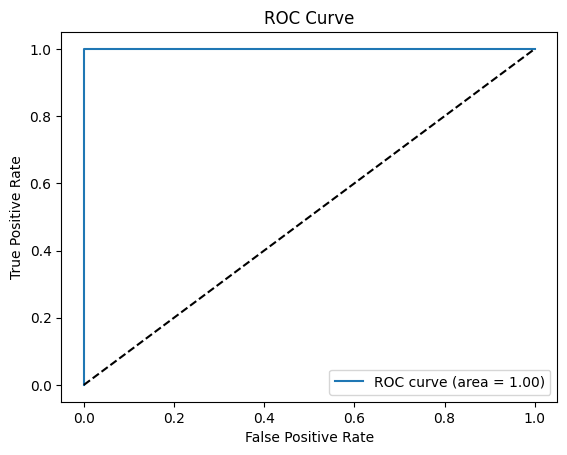

In [ ]:


# Choose best model )
final_model = best_models['LogisticRegression']
final_model.fit(X_train, y_train)

# Predict   
y_pred = final_model.predict(X_test)
y_prob = final_model.predict_proba(X_test)[:,1]

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC on test set: {roc_auc:.4f}")
print(classification_report(y_test, y_pred))

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [20]:
import joblib

joblib.dump(final_model, 'fraud_detection_model.pkl')


['fraud_detection_model.pkl']